In [1]:
'''
Data configs
'''
from final_project.smlm_3d.config.datasets import dataset_configs


# 1. Data preparation

(50, 106, 106)
Reading img...
Loading /home/miguel/Projects/uni/data/smlm_3d/bead_3D_STORM_three_instruments/20210723_beads_1mm/1mm_bead_agarose_1/1mm_bead_agarose_1_MMStack_Pos0.ome.tif
Loading /home/miguel/Projects/uni/data/smlm_3d/bead_3D_STORM_three_instruments/20210723_beads_1mm/1mm_bead_agarose_1/1mm_bead_agarose_1_MMStack_Pos0_filtered.csv
using image sharpness
139 emitters before filtering
139 emitters after proximity filtering.
139 emitters after borders


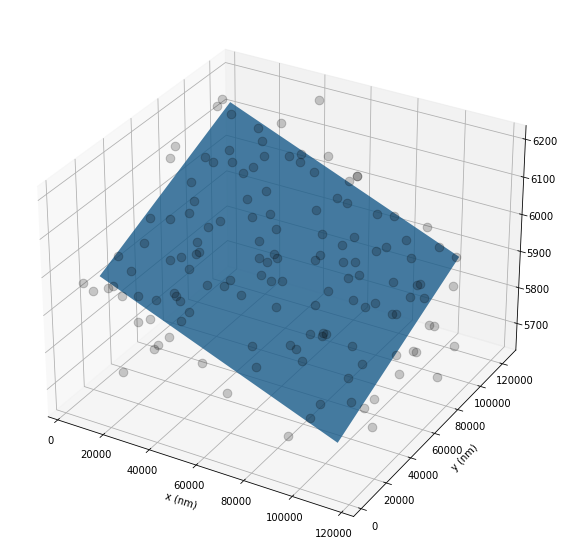

/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


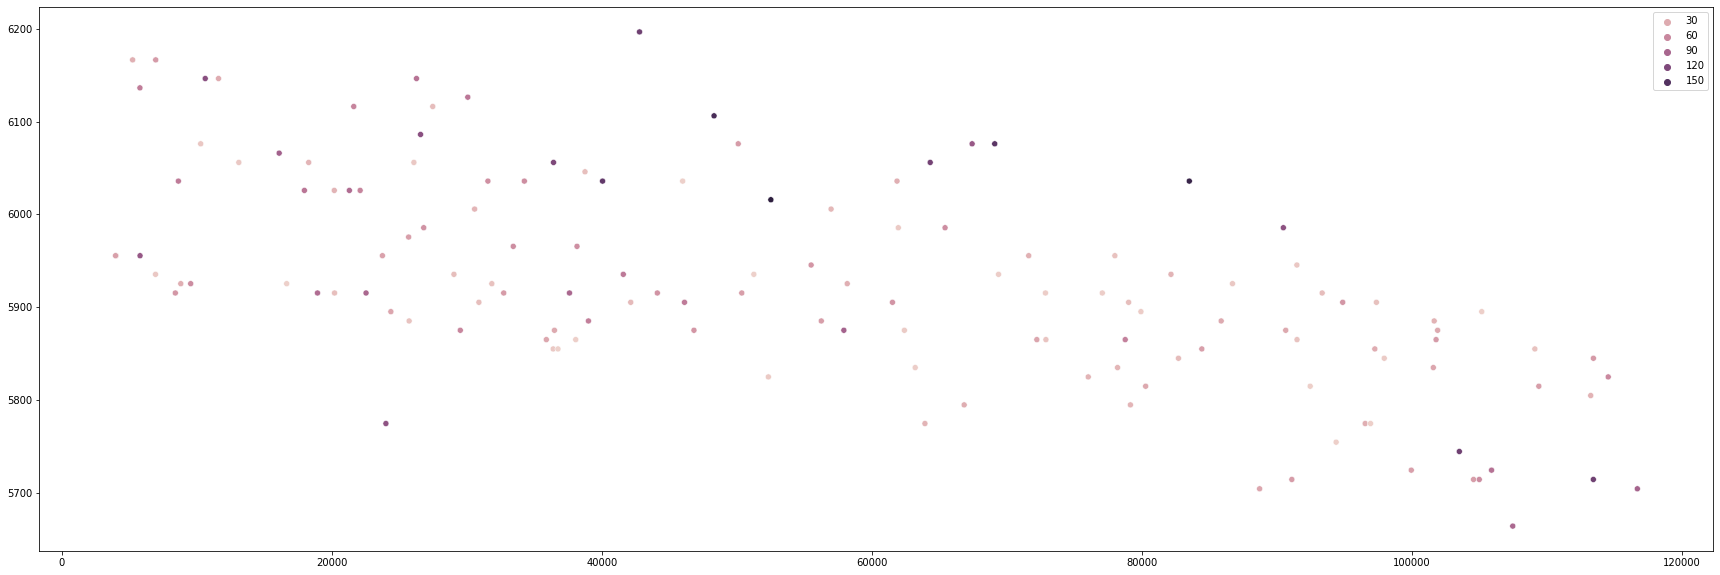

/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


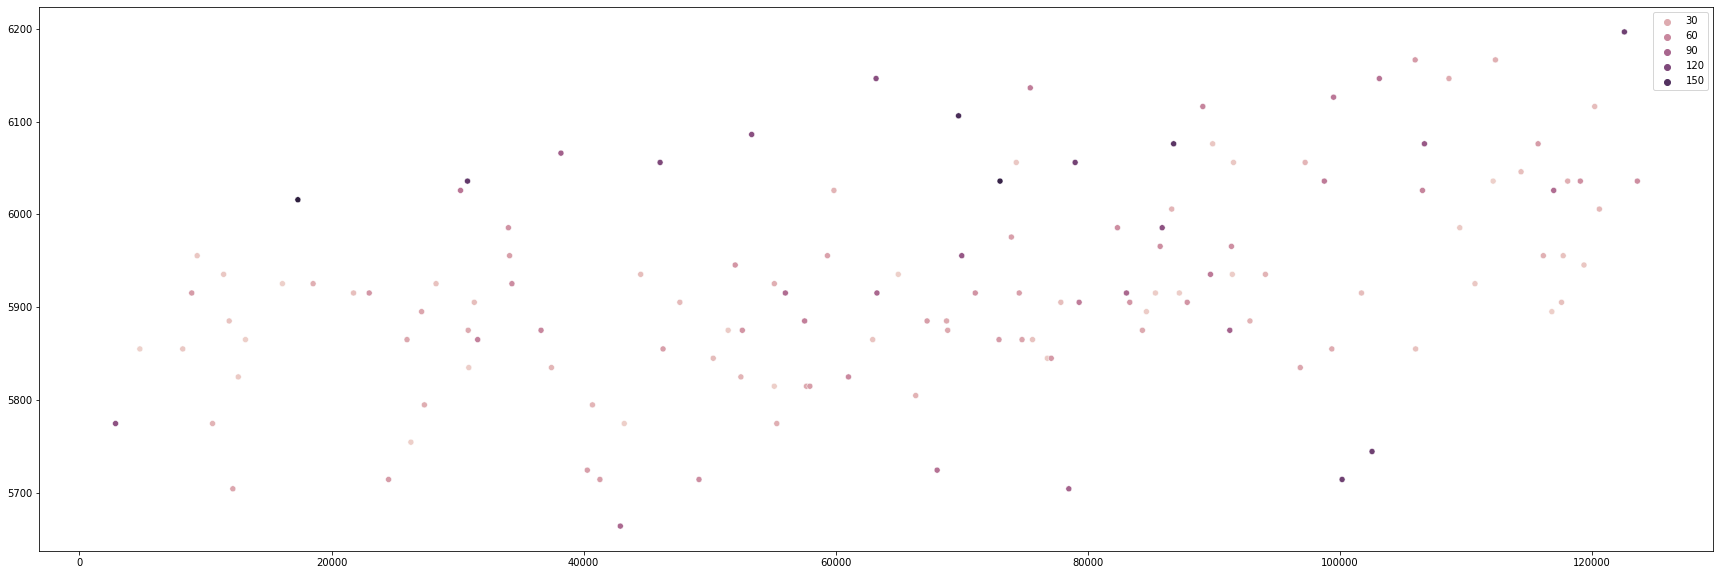

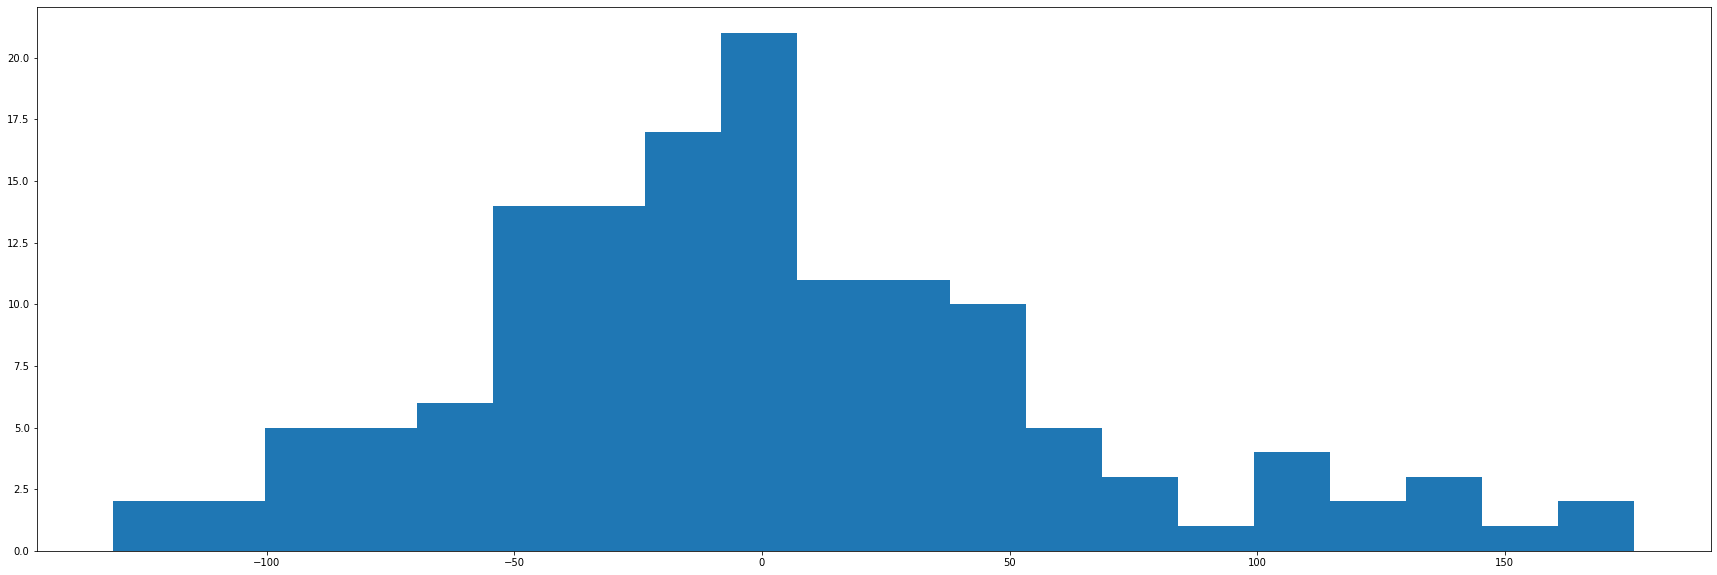

Adding noise


In [2]:
%load_ext autoreload
%autoreload 2
from final_project.smlm_3d.config.datasets import dataset_configs
from final_project.smlm_3d.data.datasets import TrainingDataSet, ExperimentalDataSet
from final_project.smlm_3d.workflow_v2 import concat_dataset_features


z_range = 1000

dataset = 'other'
cfg = dataset_configs[dataset]['training']
# cfg['csv'] = cfg['csv'].replace('_filtered', '')
print(cfg['voxel_sizes'])
train_dataset = TrainingDataSet(cfg, transform_data=False, z_range=1000, split_data=True, add_noise=True, filter_emitters_proximity=True)


Functions above do the following operations
1. Starting from a set of X/Y images of a sample, taken at different focal depths

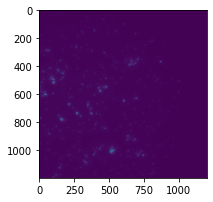

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(train_dataset.img[100])

2. For each dot of light, cut out a stack of images around the dot (below example shows focus/defocus in steps of 200nm along Z axis)

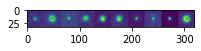

In [4]:
example_idx = 5
example_stack = np.hstack(train_dataset.data['train'][0][0][slice(example_idx*199, (example_idx+1)*199, 20)]).squeeze()
plt.imshow(example_stack)


3. Estimate 'ground truth' 0 position (focus point) of each bead using peak brightness. This is inaccurate due to high SNR ratio in image, so refine these positions by assuming dots of light sit on a plane, model new Z positions as least squares of plane and exclude poorly located points
4. Normalise each image to range [0,1]

In [5]:
example_idx = 5
example_stack = train_dataset.data['train'][0][0][slice(example_idx*199, (example_idx+1)*199, 20)].squeeze()
# Checking min/max values from for a set of images
print(example_stack.min(axis=(1,2)))
print(example_stack.max(axis=(1,2)))
      

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


(42801, 32, 32, 1)
Rows 220 Cols 10 n_spaces 2200 n_psfs 2200


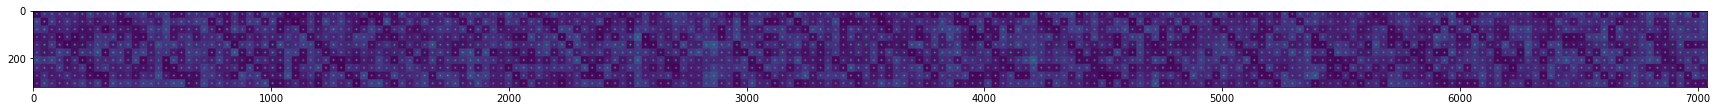

In [6]:
# checking zero-alignment of beads
from final_project.smlm_3d.data.visualise import grid_psfs
near_zero_idx = np.argwhere(abs(train_dataset.data['train'][1]) < cfg['voxel_sizes'][0]).squeeze()
near_zero_imgs = train_dataset.data['train'][0][0].squeeze()[near_zero_idx]
print(train_dataset.data['train'][0][0].shape)

plt.rcParams['figure.figsize'] = [30, 50]
plt.imshow(grid_psfs(near_zero_imgs).T)


# 2. Training the model

Currently, I'm using 2 'calibration' datasets to see if my model can adapt from one to the other.
All of the training dataset is used for training, and the 2nd dataset is used as validation.

In [7]:
import os

model_path = os.path.join('/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/experiments/model_ckpt', dataset)

def save_model(model):
    model.save_weights(model_path)
#     model.save(model_path, save_format='h5')
    print(model_path)
    print('Saved model!')

def load_model(model):
    print('Loading model...')
    print(model_path)
    model.load_weights(model_path)
#     return keras.models.load_model(model_path)


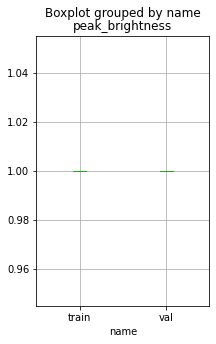

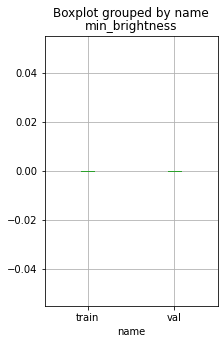

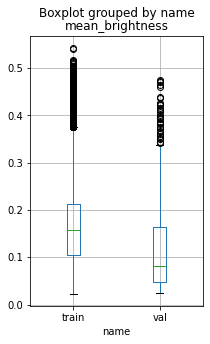

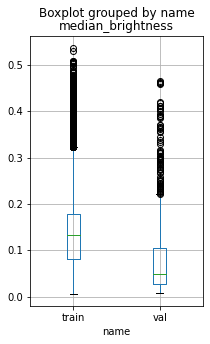

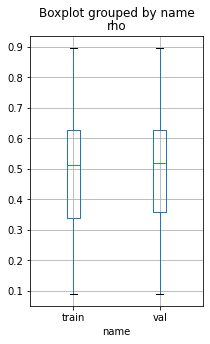

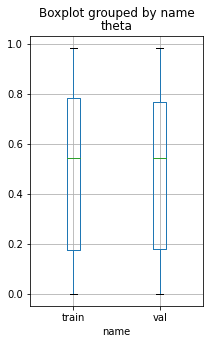

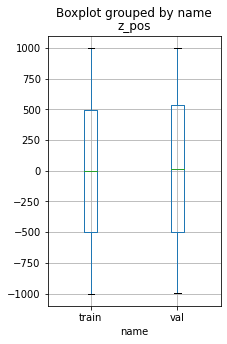

In [8]:
import pandas as pd
plt.rcParams['figure.figsize'] = [3, 5]
def gather_stats(dataset, name):
    records = [] 
    
    (imgs, coords), z_pos = dataset
    
    for img, coord, z_pos in zip(imgs, coords, z_pos):
        results = {
            'name': name,
            'peak_brightness': img.max(),
            'min_brightness': img.min(),
            'mean_brightness': img.mean(),
            'median_brightness': np.median(img),
            'rho': coord[0],
            'theta': coord[1],
            'z_pos': z_pos
        }
        records.append(results)
        
    return pd.DataFrame.from_records(records)

if 'all' not in train_dataset.data:
    train = train_dataset.data['train']
    val = train_dataset.data['val']
    
    records = []
    records.append(gather_stats(train, 'train'))
    records.append(gather_stats(val, 'val'))
    
    df = pd.concat(records)
    for col in list(df):
        if col != 'name':
            df.boxplot(by='name', column=col)
    
    

In [9]:
from scipy.optimize import curve_fit

def shift_correction(y, y_pred):
    y_pred = y_pred -  tf.math.reduce_mean(y_pred) +  tf.math.reduce_mean(y)
    return y_pred


In [10]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import RandomTranslation, GaussianNoise, Normalization, BatchNormalization, ReLU
from tensorflow.keras import Model
from tensorflow.keras import layers as Layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Conv2D

from final_project.smlm_3d.workflow_v2 import eval_model

SEED = 42
class ResBlock(Model):
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__(name='ResBlock')
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name='ResNet34')
#         self.gaussian_noise = GaussianNoise(0.1, seed=SEED)
        self.transpose = RandomTranslation(0.1, 0.1)
        self.conv1 = Conv2D(64, 7, 2, padding='same')
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.mp1 = MaxPooling2D(3, 2)

        self.conv2_1 = ResBlock(64)
        self.conv2_2 = ResBlock(64)
        self.conv2_3 = ResBlock(64)

        self.conv3_1 = ResBlock(128, 2)
        self.conv3_2 = ResBlock(128)
        self.conv3_3 = ResBlock(128)
        self.conv3_4 = ResBlock(128)

        self.conv4_1 = ResBlock(256, 2)
        self.conv4_2 = ResBlock(256)
        self.conv4_3 = ResBlock(256)
        self.conv4_4 = ResBlock(256)
        self.conv4_5 = ResBlock(256)
        self.conv4_6 = ResBlock(256)

        self.conv5_1 = ResBlock(512, 2)
        self.conv5_2 = ResBlock(512)
        self.conv5_3 = ResBlock(512)

        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(512)
        self.dp1 = Dropout(0.5)
        self.fc2 = Dense(512)
        self.dp2 = Dropout(0.5)
        self.fc3 = Dense(1)

    def call(self, inp, training):
        x, coords = inp
        # data augmentation steps
#         x = self.gaussian_noise(x, training=training)
        x = self.transpose(x, training=training)
        
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        x = self.conv4_6(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)

        x = self.pool(x)

        # Concat norm X/Y coordinates
        x = tf.concat((x, coords), axis=1)

        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        # Restrict to valid output range [-1000, 1000]    
#         x = tf.tanh(x) * 1000
        return x

    def test_step(self, data):
        (img, coords), y = data
        y_pred = self((img, coords), training=False)

        shifted_pred = shift_correction(y, y_pred)

        self.compiled_loss(y, shifted_pred, regularization_losses=self.losses)
        self.compiled_metrics.update_state(y, shifted_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}



def load_regression_model():

    # model = Sequential()
    # model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    # model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Flatten())
    # model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(1, activation='linear'))

    model = ResNet34()
    
#     model = res34()
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=0.01, decay=1e-6),metrics=['mean_absolute_error'])
    return model

model = load_regression_model()


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
def train_model(dataset, val_dataset=None):
    if not val_dataset:
        val_dataset = dataset['val']
    for k in dataset:
        imgs = dataset[k][0][0]
        norm_imgs = imgs / imgs.max(axis=(1, 2))[:, np.newaxis, np.newaxis]
        dataset[k][0][0] = norm_imgs

    model = load_regression_model()

    callbacks = [
        ReduceLROnPlateau(
        monitor='loss', factor=0.1, patience=20, verbose=True,
        mode='min', min_delta=1, cooldown=0, min_lr=1e-10,),
        EarlyStopping(monitor='val_mean_absolute_error', patience=100, verbose=True, min_delta=1, restore_best_weights=True),
    ]

#     print(dataset['train'][0][0].shape)
#     print(dataset['train'][0][1].shape)
#     print(dataset['train'][1].shape)

    history = model.fit(*dataset['train'], epochs=500, batch_size=8196, validation_data=(*val_dataset,), callbacks=callbacks, verbose=True)

    fig, ax1 = plt.subplots()
    ax1.plot(history.history['mean_absolute_error'], label='mse')
    ax1.plot(history.history['val_mean_absolute_error'], label='val_mse')
    ax1.set_yscale('log')
    ax1.legend(loc=1)
    ax2 = ax1.twinx()
    ax2.plot(history.history['lr'], label='lr')
    ax2.legend(loc=0)

    plt.show()
    return model

model = train_model(train_dataset.data)
save_model(model)


# model = load_regression_model()

Epoch 1/500
6/6 [==============================] - 11s 594ms/step - loss: 470061.1562 - mean_absolute_error: 519.8386 - val_loss: 14235421610833666258302551004807168.0000 - val_mean_absolute_error: 101854299021115392.0000 - lr: 0.0100
Epoch 2/500
6/6 [==============================] - 1s 233ms/step - loss: 191946.0312 - mean_absolute_error: 364.2155 - val_loss: 87545883829400855712106545152.0000 - val_mean_absolute_error: 253329905025024.0000 - lr: 0.0100
Epoch 3/500
6/6 [==============================] - 1s 233ms/step - loss: 137091.9531 - mean_absolute_error: 302.2415 - val_loss: 2074008509035766507110400.0000 - val_mean_absolute_error: 1238644686848.0000 - lr: 0.0100
Epoch 4/500
6/6 [==============================] - 1s 233ms/step - loss: 123857.7891 - mean_absolute_error: 278.9180 - val_loss: 308158276737244856320.0000 - val_mean_absolute_error: 15117496320.0000 - lr: 0.0100
Epoch 5/500
6/6 [==============================] - 1s 233ms/step - loss: 112353.8516 - mean_absolute_error: 

6/6 [==============================] - 1s 229ms/step - loss: 6307.0850 - mean_absolute_error: 57.6682 - val_loss: 97111.1328 - val_mean_absolute_error: 153.9540 - lr: 0.0100
Epoch 44/500
6/6 [==============================] - 1s 229ms/step - loss: 7120.9565 - mean_absolute_error: 60.6479 - val_loss: 222637.9219 - val_mean_absolute_error: 280.0286 - lr: 0.0100
Epoch 45/500
6/6 [==============================] - 1s 230ms/step - loss: 6962.6484 - mean_absolute_error: 61.0434 - val_loss: 366506.1250 - val_mean_absolute_error: 437.5981 - lr: 0.0100
Epoch 46/500
6/6 [==============================] - 1s 230ms/step - loss: 6915.4580 - mean_absolute_error: 61.3612 - val_loss: 139033.2656 - val_mean_absolute_error: 189.9995 - lr: 0.0100
Epoch 47/500
6/6 [==============================] - 1s 230ms/step - loss: 7185.5459 - mean_absolute_error: 62.4462 - val_loss: 109169.1172 - val_mean_absolute_error: 154.1259 - lr: 0.0100
Epoch 48/500
6/6 [==============================] - 1s 237ms/step - loss: 

In [ ]:
test_x, test_y = train_dataset.data['test']
pred_y = model.predict(test_x).squeeze()
error = abs(test_y-pred_y)
print(f'Mean error {np.mean(error)}')
print(f'std error {np.std(error)}')

# Mean error 32.48721585546437
# std error 34.79553158370339


In [ ]:
plt.scatter(test_y, pred_y)
plt.show()
error = abs(pred_y-test_y)
plt.boxplot(error)
plt.show()

In [ ]:
# %load_ext autoreload
# %autoreload 2

# from final_project.smlm_3d.config.datasets import dataset_configs
# from final_project.smlm_3d.data.datasets import GenericDataSet, ExperimentalDataSet, StormDataset


# cfg = dataset_configs['mi_storm']['experimental']
# storm_ds = StormDataset(cfg)

In [ ]:
# import matplotlib
# from final_project.smlm_3d.data.visualise import scatter_3d
# font = {'size'   : 14}
# plt.rcParams['figure.figsize'] = [30, 30]
# matplotlib.rc('font', **font)
# coords = storm_ds.predict_dataset(model)
# print(coords.shape)

# scatter_3d(coords)
# plt.scatter(coords[:, 0], coords[:, 1])
# plt.show()
# plt.scatter(coords[:, 1], coords[:, 2])
# plt.show()
# plt.scatter(coords[:, 0], coords[:, 2])
# plt.show()

In [ ]:
# pred_z_positions = coords[:, 2]
# sort_idx = np.argsort(pred_z_positions)
# imgs = storm_ds.data[0][sort_idx]
# img = grid_psfs(imgs[::100].squeeze())
# plt.rcParams['figure.figsize'] = [300, 300]
# plt.imshow(img)
# plt.show()



In [ ]:
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [5, 5]

from final_project.smlm_3d.data.visualise import scatter_3d, scatter_yz, show_psf_axial, plot_with_sphere, grid_psfs, plot_w_dist
from final_project.smlm_3d.config.datasets import dataset_configs
from final_project.smlm_3d.data.datasets import ExperimentalDataSet
from final_project.smlm_3d.experiments.model_sphere import fit_sphere

import seaborn as sns
import matplotlib.pyplot as plt
exp_dataset = ExperimentalDataSet(dataset_configs[dataset]['experimental'], transform_data=False, filter_localisations=False)

# psfs = grid_psfs(np.moveaxis(exp_dataset.data[0], 3, 1)).squeeze()
# print(psfs.shape)

# plt.imshow(psfs)
# plt.show()

def eval_sphere_fit(coords, z_diff):
    radius = 5e5 + 50
    cols = ['x', 'y', 'z']
    orig_df = pd.DataFrame(coords, columns=cols)
    centre, res = fit_sphere(orig_df, radius)
    
    plt.figure()
    ax = plt.gca()
    sns.scatterplot(coords[:, 0], coords[:, 2], hue=z_diff)
    circle = plt.Circle((centre[1], centre[2]), radius=radius, fill=False)
    ax.add_artist(circle)
    plt.xlabel('x')
    plt.ylabel('z')
    plt.show()
    plot_w_dist(centre, coords, radius, z_diff)
    worst_imgs = np.argsort(abs(res))[::-1]
#     for i in worst_imgs[0:10]:
#         print(i, z_diff[i], res[i])
#         plt.imshow(exp_dataset.data[0][i])
#         plt.show()
    
    res = abs(res)
#     res = res[res < np.percentile(res, 75)]
    plt.boxplot(res)
    plt.show()
    print(np.mean(res))
    print(np.std(res))
    return res
    
    

scatter_yz(exp_dataset.xyz_coords)
original_coords = exp_dataset.xyz_coords.copy()
# eval_sphere_fit(original_coords)

new_coords = exp_dataset.predict_dataset(model)
z_diff = new_coords[:, 2] - original_coords[:, 2]
res = eval_sphere_fit(new_coords, z_diff)


# plt.figure()
# ax = plt.gca()
# plt.scatter(original_coords[:, 0], original_coords[:, 2])
# circle = plt.Circle((5e5, old_sphere_centre[2]), radius=5e5, fill=False)
# ax.add_artist(circle)
# plt.xlabel('x')
# plt.ylabel('z')
# plt.show()


# df.to_csv('/home/miguel/Projects/uni/phd/smlm_z/tmp.csv', index=False)


In [ ]:
plt.rcParams['figure.figsize'] = [30, 50]

def order_all_psfs(c, psfs):
    sort_idx = np.argsort(c)
    psfs_ordered = psfs[sort_idx]
    plt.imshow(grid_psfs(psfs_ordered))
    plt.show()

# exp_dataset.prepare_debug()
# n_psfs = exp_dataset.csv_data.shape[0]
# psfs = []
# for i in range(n_psfs):
#     psfs.append(exp_dataset.debug_emitter(0, z_range=1000, normalize=False)[0].squeeze())
order_all_psfs(res, exp_dataset.data[0].squeeze())
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(np.sort(res))
plt.show()

In [ ]:
from final_project.smlm_3d.workflow_v2 import eval_model, shift_correction as original_shift_correction

ae = np.mean(abs(test_y - pred))


plt.scatter(test_y, pred, alpha=0.25, marker='+')
plt.xlabel('True position (nm)')
plt.ylabel('Predicted position (nm)')
plt.show()
shifted_pred = original_shift_correction(test_y, pred)

shifted_ae = np.mean(abs(test_y-shifted_pred))

print(ae)
print(shifted_ae)




In [ ]:
plt.scatter(test_y, pred, label=str(i), alpha=0.5, marker='x')
plt.show()

ae = test_y.squeeze()-pred.squeeze()

plt.boxplot(ae)
plt.show()
print(np.mean(ae))

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

ae = list(map(np.mean, chunks(ae, 199)))

In [ ]:
import seaborn as sns
sub_df = exp_dataset.csv_data
sub_df['mean_error [nm]'] = ae

sub_df['id'] = list(range(sub_df.shape[0]))
# cols = ['chi2']
# for c in cols:
#     sub_df.plot.scatter(c, 'mean_error [nm]')
#     plt.show()

worst_images = sub_df.sort_values(by='mean_error [nm]', ascending=False)
worst_idx = list(worst_images['id'][0:5])
best_idx = list(worst_images['id'][-5:-1])

for idx in worst_idx:
    start = idx*(199)
    end = (idx+1)*199
    imstack_idx = slice(start, end, 25)
    imstack = exp_dataset.data['all'][0][0][imstack_idx]
    for img in imstack:
        plt.imshow(img)
        plt.show()
    print('break')